### Read in and analyze data from Wenhan and Harvey's optimization codes
Note: this program assumes that the data will be in a the same directory as the "Data" directory which holds all of the data from these runs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime
import pytz
import pickle
from mpl_toolkits.mplot3d import Axes3D
import os

%matplotlib inline
plt.rcParams['figure.dpi']=200
plt.rcParams['font.family'] = 'Serif'

In [3]:
def savePNG(pngname): 
    plt.savefig(pngname+".png", bbox_inches="tight", facecolor='w')
    
def load_data(filename):
    with open(filename) as datafile:
        content = datafile.readlines()
        data = np.array([np.fromstring(c, sep=' ') for c in content])
    return data

def load_files(data_dir, start_with=''):
    # return a list of nd arrays containing datafiles in the data_dir
    datafiles = [s for s in os.listdir(data_dir) if s[:len(start_with)] == start_with ]
    print("%d data files found"%len(datafiles))
    
    dataset = []
    for i in range(len(datafiles)):
        datafile = datafiles[i]
        dataset.append(load_data(data_dir+datafile))
    
    return dataset

In [4]:
labels = ['loop time [s]','wall time [s]',r'beam current [$\mu$A]','drain current [mA]','bias current[mA]',
          r'P$_\mathrm{inj}$ [torr]',r'P$_\mathrm{ext}$ [torr]',
          r'I$_\mathrm{inj}$ [A]',r'I$_\mathrm{ext}$ [A]',r'I$_\mathrm{mid}$ [A]',r'I$_\mathrm{sext}$ [A]',
          'xray Src']

In [5]:
labels[8]

'I$_\\mathrm{ext}$ [A]'

In [6]:
# Load all files starting with "mon" in the data_dir
exp_num = 3
data_dir = "Data/First Run/" if exp_num == 1 else "Data/Second Run/"

dataset = load_files(data_dir, start_with='mon')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Second Run/'

In [7]:
xpts=[]
ypts=[]
zpts=[]
sizepts=[]
magpts=[]

xi = 9
yi = 8
zi = 7
szi = -1
mgi = 2

for setnum in range(len(dataset)):
    data = dataset[setnum]*1
    try:
        inewset=np.where(np.diff(data[:,0])<0)[0]
    except:
        continue

    for i in range(len(inewset)):
        iend=inewset[i]+1
        if i==0: istart=0
        xpts.append(np.mean(data[istart:iend,xi]))
        ypts.append(np.mean(data[istart:iend,yi]))
        zpts.append(np.mean(data[istart:iend,zi]))
        sizepts.append(i)
        magpts.append(np.mean(data[istart:iend,mgi]))
        istart=iend

NameError: name 'dataset' is not defined

## Data Visualization

In [8]:
from dataclasses import dataclass
from typing import Optional
@dataclass
class Frame3D: 
    xmin: Optional[float] = None
    xmax: Optional[float] = None
    ymin: Optional[float] = None
    ymax: Optional[float] = None
    zmin: Optional[float] = None
    zmax: Optional[float] = None
    xlabel: str = "x"
    ylabel: str = "y"
    zlabel: str = "z"

In [9]:
test_frame = Frame3D(xmax=1)
test_frame.xmin

In [10]:
# # save all data
# data_list = [xpts, ypts, zpts, sizepts, magpts]

from VenusOpt.utils import loadXy
run_idx = '1'
X, y, X_var = loadXy("accumulated_weekend_data.h5", run_idx=run_idx, scaleX=False)


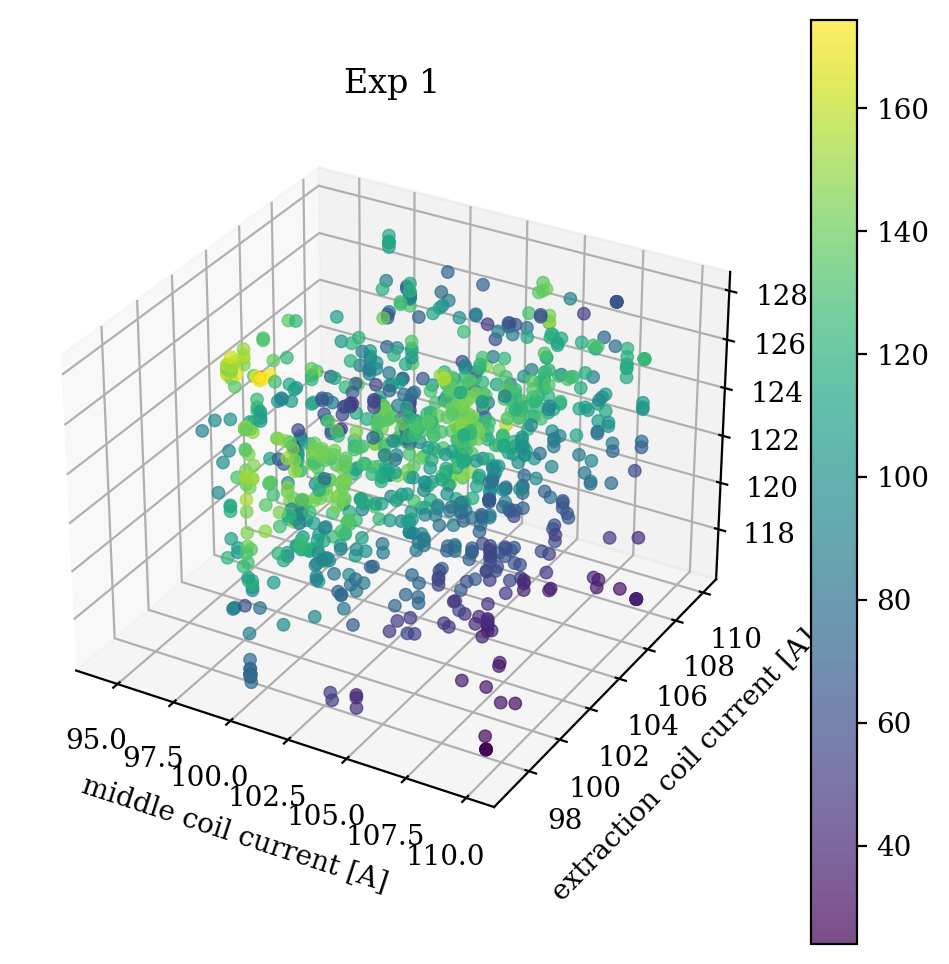

In [13]:
import numpy as np
frame = Frame3D(95, 110, 97, 110, 117, 130, 
                )
frame = Frame3D(xmin=90, xlabel='middle coil current [A]', 
                ylabel='extraction coil current [A]', 
                zlabel='other coil current [A]')

def plot4d_data(X: np.ndarray, y: np.ndarray, frame=Frame3D(), best_highlight=False, title="test", c_label="", save=False):
    """Plot 4 Dimensional Data. Optionally saves to "{title}.png"

    Args:
        X (np.ndarray): Data matrix. Shape (N, 3), where N is the number of data points
        y (np.ndarray): Label matrix. Shape (N, )
        frame (Frame3D, optional): 3D frame of the plot. Any limit not set in frame will be auto fitted. 
        best_highlight (bool, optional): Highlight the point with largest y value. Defaults to False.
        title (str, optional): Title of the plot. Defaults to "test".
        c_label (str, optional): Colorbar label. Defaults to empty string.
        save (bool, optional): Choose to save image. Defaults to False. 
    """
    assert X.shape[0] == y.shape[0]
    
    if len(y.shape) > 1:
            # TODO: plot points with different sizes as the 5th dimension
            raise NotImplementedError()
    
    xpts, ypts, zpts, sizepts, magpts = list(X[:,0]), list(X[:,1]), list(X[:,2]), list(np.zeros_like(X[:,0])), list(y)
    
    # plotting
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    
    xr, yr, zr, sr, mr = xpts[:],  ypts[:],  zpts[:], sizepts[:], magpts[:]
    if best_highlight:
        # seperate the best from the rest
        bi = np.argmax(magpts) # best index
        xb, yb, zb, sb, mb = xr.pop(bi),  yr.pop(bi),  zr.pop(bi), sr.pop(bi), mr.pop(bi)

    graph = ax.scatter(xr, yr, zr,
            c=mr, vmin=min(magpts),vmax=max(magpts), linewidths=0.5, alpha=.7)
    if best_highlight:
        ax.scatter(xb, yb, zb, 
                c=mb, vmin=min(magpts),vmax=max(magpts), edgecolor='red', linewidths=0.5, alpha=.7)

    cbar = fig.colorbar(graph)
    cbar.set_label(c_label)
    ax.set_xlabel(frame.xlabel)
    ax.set_ylabel(frame.ylabel)
    ax.set_zlabel(frame.zlabel)

    if frame.xmin and frame.xmax: ax.set_xlim([frame.xmin,frame.xmax])
    if frame.ymin and frame.ymax: ax.set_ylim([frame.ymin,frame.ymax])
    if frame.zmin and frame.zmax: ax.set_zlim([frame.zmin,frame.zmax])

    plt.title(title)
    if save: plt.savefig(title+".png")
    plt.show()

plot4d_data(X, y, frame=frame, best_highlight=True, title="Exp %s"%run_idx, )

# Model Loading Example

In [9]:
gpr_model = pickle.load(open("Models/gprMatern0.66.dump","rb"))
normalizer = lambda X: (X - [103.16726412, 103.05644853, 122.86389106] )/ [3.54492885, 3.87407133, 3.28592364]
func = lambda x,y,z: gpr_model.predict(normalizer(np.array([[x,y,z]])))[0]

In [10]:
func(110,110,120)

43.99047570001613